### April 25, 2019


# 1. Introduction

This document compares the PnL's of three execution methods: market taking, opportunistic market making with order resting at "your side" price (OMMside), and opportunistic market making with order resting at mid price (OMMmid).

In market taking part, we match each order with appropriate quotation and then represent the result. In OMMmid and OMMside parts, we control maximum time to execution and the stop loss. The stop loss threshold is set as the product of a parameter k times the rolling 20-quotation standard deviation. We test k from 0.5 to 3 and TTE from 5 to 60 seconds to find the optimal pair of parameters. The results of OMMmid and OMMside are represented in each part.

Then we analyze the PnL, time to execution, and the reasons of execution based on previous statistics we calculated. Influence of time to execute on PnL is also discussed. The Alpha engine analysis focuses on the differences of the orders generated by the three engines: SOM, DIS, and MAR. Plausible interpretation is also proposed.


## 1.1 Load and Preprocess Data

In this part we load the data from given files. A point to mention is that the format for date in these two files are different, which will cause problem when we compare these date later. The difference of datetime can be shown from the below two dataframes. Our solution is to transform both date to datetime object, which is like "%m/%d/%Y %H:%M:%S.%f". We will do this transform when we implement the yield_result function.

In [6]:
df_mkt.head(3)

,Datetime,Bid,Ask
0,01/07/2018 22:02:03.832,1.35560,1.35616
1,01/07/2018 22:02:03.845,1.35560,1.35617
2,01/07/2018 22:02:03.851,1.35554,1.35617


In [7]:
df_orders.head(3)

,BuyOrSell,Datetime,Alpha
0,1,2018-01-07 19:07:49.749000,SOM
1,1,2018-01-07 19:15:23.152300,SOM
2,-1,2018-01-08 07:38:48.384800,SOM


# 2. Market Taking

## 2.1 Process Explanation

In this process, we match quotation for each order by finding the closest quotation that is prior to the time when the order is place, because this is the active quotation at this time.

Meanwhile, we record the indice of the market data if this piece of data meets the requirement mentioned above. The stored indice are used as the starting points for searching execution price for OMMmid and OMMside, which significantly accelerate the processes.

## 2.2 Result Demonstration

In [8]:
result_mt_display.head(5)

,OrderTime,OfferTime,BuyOrSell,Bid,Ask,Alpha,PnL(*10^-5)
0,2018-01-08 07:38:48.384800,2018-01-08 07:38:46.995,-1,1.35422,1.35423,SOM,-0.5
1,2018-01-08 08:10:55.105500,2018-01-08 08:10:54.348,-1,1.35411,1.35416,SOM,-2.5
2,2018-01-08 08:19:10.191000,2018-01-08 08:19:10.083,-1,1.35377,1.35379,SOM,-1.0
3,2018-01-08 08:23:16.231600,2018-01-08 08:23:12.477,-1,1.35352,1.35355,SOM,-1.5
4,2018-01-08 08:34:40.344000,2018-01-08 08:34:39.602,-1,1.35381,1.35383,SOM,-1.0


# 3. Opportunistic Market Making - Mid

## 3.1 Function Explanation

reachTTE(order_time, mkt_time, delta)
    
    Given the time of an order is placed and a current market time, if an order reaches max TTE, return True; otherwise, return False

reachSL(origPrice, info_mkt, signal, SL)

    Input: origPrice is the price a trader would use if they had placed an market order; info_mkt is a pandas series containing quotation time, bid and ask price; SL is the preset stop loss amount, in form of positive.
    Output: if the loss reaches SL, return True; otherwise, return False

reachWantedPrice(wantedPrice, info_mkt, signal)
   
    Input: the wanted price; info_mkt is the same as what it is in reachSL(); signal==1 for buying and -1 for selling
    Output: if the market price reaches wanted price, return True; otherwise, return False

yield_result_mid(TTE, k, result, dt_orders, idx_mkt, mkt_std, PnL_mkt_order)

    Input:  TTE: max time to execution, in unit of seconds;
            k: the multiplier; k times rolling 20-day standard deviation of market mid price is used as our stop loss threshold; 
            result: the dataframe that contains market taking information
            dt_orders: an array or list that contains streams of time of market quotation
            idx_mkt: the list of indice (in integers) of market information that coresponds to each order
            mkt_std: array or list of rolling 20-day market mid price standard information
            PnL_mkt_order: the list of PnL's of market taking method
    Output: dataframe of summaries of orders
    Process: Iterate over order list. For each order, we search for the quotation that meets our wanted price in ascending order of time. 
    
The search starts from the time when the order is place and this is achieved by using the list idx_mkt that we stored in processing market taking case. For each quotation and corresponding time, we check if stop loss or max time to execute is triggered. Once wanted price meets or any one of the triggers is activated, the order is executed, and we record the information about this order, the market information at this time, and the reason for execution.

The difference between this function and yield_result_side() is the the wanted price being set differently.

## 3.2 Optimization
#### Methods to select SL and maxTTE threshold

When it comes to opportunistic market making, we need to add to constraints. One is a stop loss point and the other is the max time to execute. The stop loss point(SL) means the largest amount of loss you can suffer from,so when you reach this point, you must fullfill your order immediately to prevent further loss. The max time to execute(maxTTE) is the time constraint. You must fullfill your order before this maxTTE. Opportunistic Market Making acutally means you wait and bet on market moving in your favor, but you cannot wait too long time, so maxTTE is important. 

    gain from an OMM strategy = gain from delta ask price

First, we start with discussing the choice of SL. From the defination of SL above, we conclude that SL means the largest amount of loss you are willing to suffer from, so SL actually corresponds to a "price" which is differ from the origin price you get. Making transaction under this new price will cause a loss compare to making transaction under the original price. So as a result, we define SL as a movement of price. Then, it is reasonable to choose the standard deviation of price as SL. In this project, we chosse the mid price. Also, as time goes by, the volitality of price changes, so we need to calculate a rolling standard deviation. We choose 20 as the window of this rolling deviation. Finally, we need to decide how many times of the standard deviation's deviate from origin price is our stop limit point. That is, k. During our optimization process, our potential k is [0.5,0.6,0.7,0.8,0.9,1,1,2,1.4,1.6,1.8,2,2.5,3]

Second, we discuss the max time to execute. MaxTTE is easier to define. It is the max time we are allowed to fullfill the order. We can wait the market to offer our target price within this time limit. Although setting maxTTE to infinite almost guarantee that we can reach our target price, we cannot do that since our trading strategy requires we fullfill the order quickly. In our project, we assume TTE should be less than one minute and our potential maxTTE is [5,10,15,...,45,50,55,60].

The way to choose the best parameters is to comapre the median_pnl. We always perfer the larger median_pnl. So we implement the optimized_result_mid function to get the median_pnl and we will provide the dataframe showing the best 5 groups of parameters. We noticed that the median_pnl would be the same for many groups of k & maxTTE. So we add 2 more rules. The first is that we always perfer shorter max_tte. The second is that we perfer smaller SL. After applying these two rules we can get our rank, thus get the optimized function.

We also implement a plot function to show how the choice of k & maxTTE will affect the median_pnl. In the scatter graph, the size of the points reflects the amount of median_pnl, the bigger the better. And we annotate the best choice.

The best parameters for OMMMid is k = 2.5 and maxTTE = 20. And we achieve 0 median_pnl. Which means on average we achieve our traget price( mid price) and thus we do not pay the half spread.

,k,max_tte,median_pnl
147,2.5,20,0.0
159,3.0,20,0.0
148,2.5,25,0.0
160,3.0,25,0.0
89,2.0,30,0.0


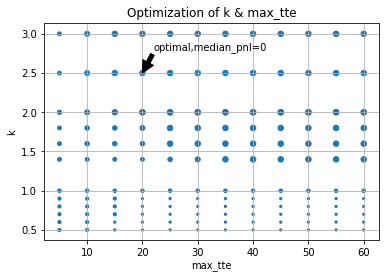

In [17]:
plot_optimized_mid(optimized_result_mid)

## 3.3 Result Demonstration

Reason for execution explanation: 
 
    1 for wanted price met
    2 for maximum time to execution reached
    3 for stop loss triggered

In [18]:
optimal_mid_display.head()

,OrderTime,OfferTime,TimeToExe,BuyOrSell,OriginalPrice,WantedPrice,Bid,Ask,Alpha,ReasonOfExe,PnL(*10^-5)
0,2018-01-08 07:38:48.384800,2018-01-08 07:38:50.407,00:00:02.022200,-1,1.35422,1.354225,1.35424,1.35423,SOM,1,1.5
1,2018-01-08 08:10:55.105500,2018-01-08 08:10:55.800,00:00:00.694500,-1,1.35411,1.354135,1.35414,1.35417,SOM,1,0.5
2,2018-01-08 08:19:10.191000,2018-01-08 08:19:12.250,00:00:02.059000,-1,1.35377,1.353780,1.35372,1.35377,SOM,3,-6.0
3,2018-01-08 08:23:16.231600,2018-01-08 08:23:34.151,00:00:17.919400,-1,1.35352,1.353535,1.35349,1.35354,SOM,3,-4.5
4,2018-01-08 08:34:40.344000,2018-01-08 08:34:40.821,00:00:00.477000,-1,1.35381,1.353820,1.35382,1.35383,SOM,1,0.0


# 4. Opportunistic Market Making - Side

## 4.1 Function Explanation

yield_result_side(TTE, k, result, dt_orders, idx_mkt, mkt_std, PnL_mkt_order)
    
    Input:  TTE: max time to execution, in unit of seconds;
            k: the multiplier; k times rolling 20-day standard deviation of market mid price is used as our stop loss threshold; 
            result: the dataframe that contains market taking information
            dt_orders: an array or list that contains streams of time of market quotation
            idx_mkt: the list of indice (in integers) of market information that coresponds to each order
            mkt_std: array or list of rolling 20-day market mid price standard information
            PnL_mkt_order: the list of PnL's of market taking method
    Output: dataframe of summaries of orders
    Process: Iterate over order list. For each order, we search for the quotation that meets our wanted price in ascending order of time. 

The search starts from the time when the order is place and this is achieved by using the list idx_mkt that we stored in processing market taking case. For each quotation and corresponding time, we check if stop loss or max time to execute is triggered. Once wanted price meets or any one of the triggers is activated, the order is executed, and we record the information about this order, the market information at this time, and the reason for execution.
    
The difference between this function and yield_result_mid() is the the wanted price being set differently.

## 4.2 Optimization

In this part we calculate the optimal parameters, which are k & maxTTE as we discussed above. The optimal parameters are k = 3 & maxTTE = 60. The k and maxTTE for OMMSide strategy are both larger than that for OMMMid strategy. It make sense since in the OMMSide strategy, we need the market to move more in order to get our target price. So we need to take more risk of price movement(which means larger sl) and more time to let the transaction deal(which means larger maxTTE).

,k,max_tte,median_pnl
167,3.0,60,0.0
164,3.0,45,0.0
165,3.0,50,0.0
166,3.0,55,0.0
162,3.0,35,-0.0


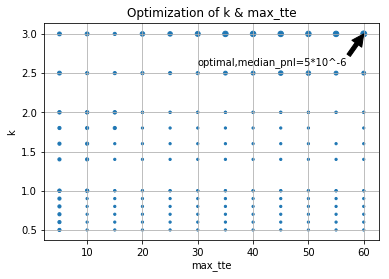

In [31]:
plot_optimized_side(optimized_result_side)

## 4.3 Result Demonstration

Reason for execution explanation: 
    
    1 for wanted price met
    2 for maximum time to execution reached
    3 for stop loss triggered

In [28]:
optimal_side_display.head()

,OrderTime,OfferTime,TimeToExe,BuyOrSell,OriginalPrice,WantedPrice,Bid,Ask,Alpha,ReasonOfExe,PnL(*10^-5)
0,2018-01-08 07:38:48.384800,2018-01-08 07:38:50.407,00:00:02.022200,-1,1.35422,1.35423,1.35424,1.35423,SOM,1,1.5
1,2018-01-08 08:10:55.105500,2018-01-08 08:11:01.082,00:00:05.976500,-1,1.35411,1.35416,1.35416,1.35418,SOM,1,2.5
2,2018-01-08 08:19:10.191000,2018-01-08 08:19:12.250,00:00:02.059000,-1,1.35377,1.35379,1.35372,1.35377,SOM,3,-6.0
3,2018-01-08 08:23:16.231600,2018-01-08 08:23:34.151,00:00:17.919400,-1,1.35352,1.35355,1.35349,1.35354,SOM,3,-4.5
4,2018-01-08 08:34:40.344000,2018-01-08 08:34:40.878,00:00:00.534000,-1,1.35381,1.35383,1.35383,1.35384,SOM,1,1.0


# 5. Analysis on Three Approaches
## 5.1 Analysis on PnL

The following PnL list is calculated with parameters as follows:

    k = 2.5 and TTE = 20s for mid case
        
    k = 3.0 and TTE = 60s for side case
        
These parameters are considered optimal as the conclusion from part 3 and part 4.

We use the optimized parameters for each approach, so that the intrinsic property of each apprach can be revealed.

In [34]:
PnL_all_display

,MT,OMMMid,OMMSide
PnL_min(*10^-4),-2.600,-2.400,-2.400
PnL_median(*10^-4),-0.200,0.000,0.050
PnL_mean(*10^-4),-0.190,-0.193,-0.161
PnL_std(*10^-4),0.151,0.337,0.430


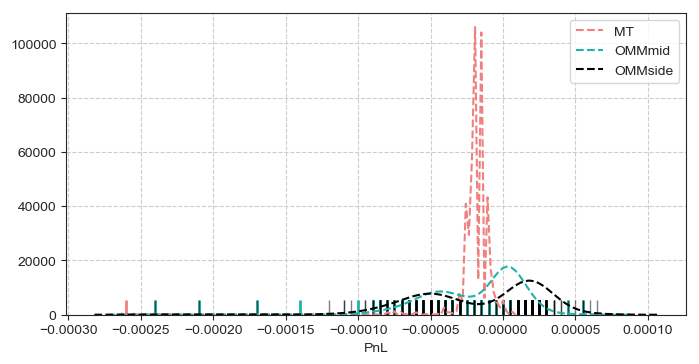

In [35]:
distPnL(result_mt,"MT", optimal_mid, "OMMmid", optimal_side, "OMMside")

The table of PnL shows that as we set the wanted price more favorable to us (MT -> OMMmid -> OMMside), the median and mean of PnL tend to be increased; the minimum PnL does not have significant difference; the standard deviation becomes larger. One thing to be noticed is that the median of PnL is much more sensitive to the kind of approach than the mean of PnL, according to this table.

We feel it helpful to draw the PnL distributions of these three approaches. In the graph above, we can find that the PnL of market taking strategy is highly concentrated, and the distribution spreads more as the target price is set more favorable to us. The distribution curves of OMMmid and OMMside have similar shapes while OMMside has a fatter tail.

A trivial conclution of "higher risk, high return" can be made: as the specified price of the limit order goes farther away from the spot market price, the trader could expect higher return and also bears high risk.

Next, let's consider if the risk of taking OMMmid or OMMside approach is worthwhile. The law of large numbers should come into play in high-frequency trading. This leads to the reasonable assumption that the total return should not be far away from the mean. Therefore, mean PnL becomes the most critical statistic. We can see from the table that OMMmid's mean PnL is equal to MT's mean PnL, while OMMside has a higher mean PnL. **Consequently, we would suggest not to apply OMMmid apporach because it takes more risk than MT apporach does but does not exceed MT approach in term of return. And we believe the risk of OMMside approach brings some return.**

## 5.2 Analysis on Time to Execution

Time to execution and triggers of execution are not applicable to market taking approach. So, we just compare OMMmid and OMMmid for these metrics.

In [47]:
summary_OMMs

,OMMSide,OMMMid
meanPnL(*10^-4),-0.161,-0.193
meadianPnL(*10^-4),0.050,0.000
meanTTE(seconds),15.180,7.794
medianTTE(seconds),7.198,4.302
PriceMetCount,188.000,196.000
TimeLimitCount,29.000,54.000
StopLossCount,150.000,117.000


Making a horizonal comparison, we find that OMMside takes much more time to be executed than OMMMid takes, both true with mean or median measure. To be resting within the spread means risk; and in return, we can see that OMMSide has higher mean of PnL.

Making a vertial comparison, we find that the mean of TTE is much higher than median of TTE. This pattern indicates a pirce of fraction of TTE distribution: while over half orders can be executed within a short period of time, some orders takes very long time, or meet time limit, until they are executed, which drives the mean TTE much larger. The orders that take long time should be be main source of risk, and traders may want to pay special attention to this situation.

## 5.3 Analysis on Reasons of Execution

OMMSide are more likely to trigger stop loss than OMMMid. This makes sense because while we allow the orders to wander in a bigger interval, they are more likely to end up with extreme situations--that is, stop loss control.

In this case, OMMMid triggers more time limit control than OMMside, but the sample size is relatively small. So, the differnce between time limit trigger needs more data for a more confident conclusion.

# 6. Influence of Time to Execute on PnL

In this part we present a graph showing the relationship between median pnl and maxTTE. We set k as constant, which is 2.5 for OMMMid median_pnl and 3 for OMMSide median_pnl. The result shows that the median_pnl generally increases as the length of maxTTE increases, and it make sense since as the maxTTE increases, we always have more chance to get our target price.

As the graph below suggests, the OMMMid median_pnl reaches zero(which is the best theoretical result we could get) when we set maxTTE equal 15. The OMMSide median_pnl takles longer time to reach zero. It reaches zero when maxTTE equals 35, and become positive when maxTTE equals 60. It is because we need the market price move more when we select OMMSide strategy, so we need more time.

<Figure size 432x288 with 0 Axes>

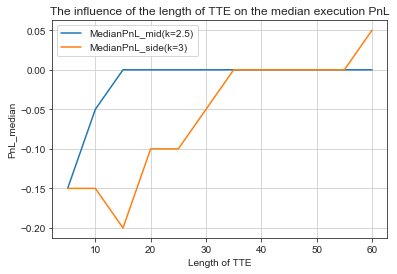

In [50]:
plot_TTEvsPnL(TTEvsPnL)

# 7. Alpha Engine Analysis

## 7.1 Alpha Engine Analysis - Market Taking

In [60]:
display_7_1(alpha_analysis_dt(result_mt))

,MeanPnL(*10^-5),MedianPnL(*10^-5)
SOM,-2.00,-2.0
DIS,-1.73,-1.5
MAR,-1.64,-1.5


The (only) bridge between alpha engines and PnL (as well as other statictics) is the timing of placing orders.  We learn from the mean and median PnL above that **DIS and MAR** are likely to initiate orders when the bid/offer **spread is low**. 


## 7.2 Alpha Engine Analysis - OMMmid

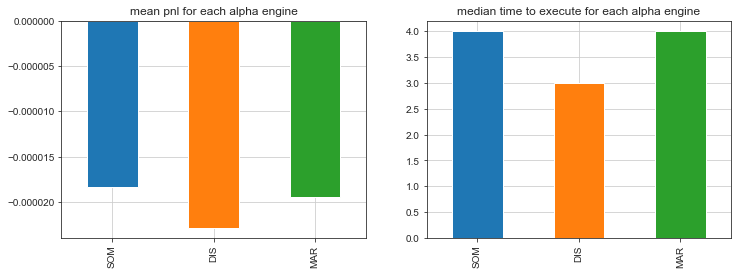

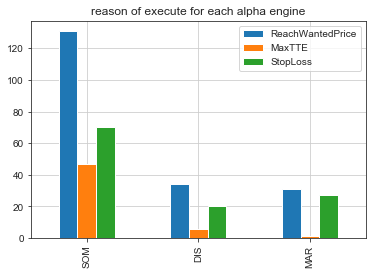

In [61]:
plot_alpha_analysis(alpha_analysis(optimal_mid))

We learn from the histograms that:

1. Mean PnL: SOM > MAR > DIS (the difference bwtween MAR and DIS is relatively small)
2. Median time to execution: SOM = MAR > DIS.
3. MAR is most likely to trigger loss control and SOM is most likely to reach max TTE.

As we have discussed in 7.1, SOM tends to enter market when the spread is higher, compared with the other two engines. This means higher "basic loss" for SOM. However, SOM has the best PnL performance in OMMmid performance.
Since SOM's time to execute does not earn advantage against other two engines, we interpret the reversion as follows: market tends to move in favor of the trader shortly after the time that SOM chooses to enter market 

One should also notice the imbalance of the sample sizes of these three engines. The relatively low number of DIS and MAR data points means relatively high coindidence and thus may weaken the validity of previous analysis.


#### Distribution of PnL of each engine

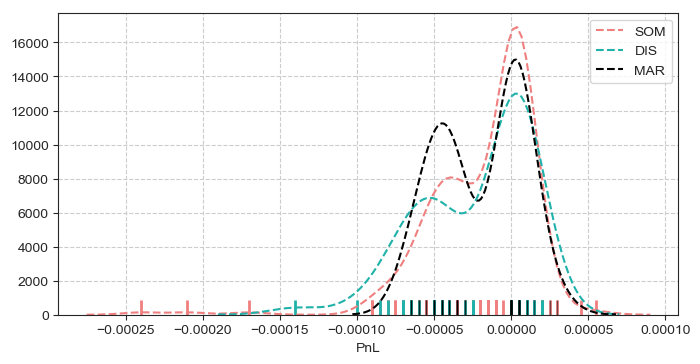

In [62]:
distPnL(df_SOM_mid,"SOM",df_DIS_mid,'DIS',df_MAR_mid,'MAR')

## 7.3 Alpha Engine Analysis - OMMside

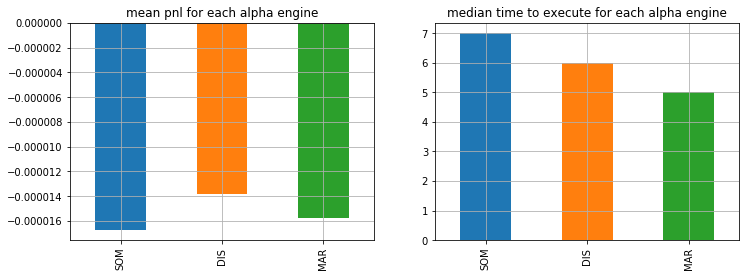

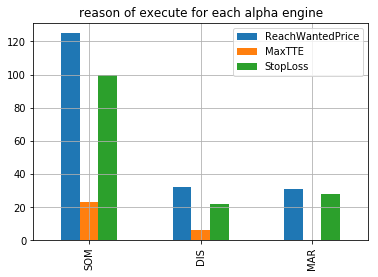

In [47]:
plot_alpha_analysis(alpha_analysis(optimal_side))

We learn from the histograms that:

1. Mean PnL: DIS > MAR > SOM
2. Median time to execution: SOM > DIS > MAR
3. MAR is most likely to trigger loss control.

SOM, once again, ranks bottom in term of mean PnL ranking. Here is our interpretation: when we assign much space for limit order to wander (what we do in OMMside approach), the orders initiated by SOM tend to move against the traders in the process. The long time to execution of SOM verifies that it is harder for SOM orders to meet with the wanted price.


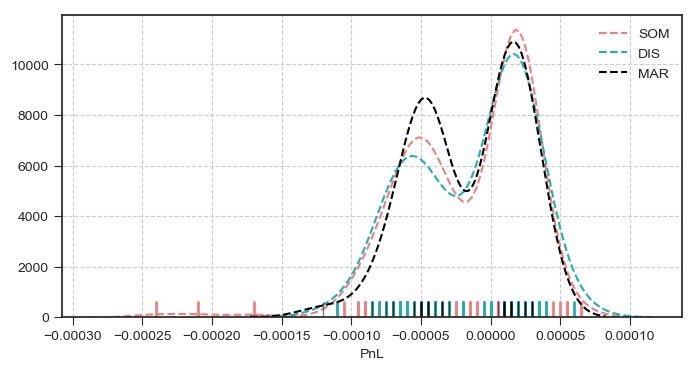

In [50]:
distPnL(df_SOM_side,"SOM",df_DIS_side,'DIS',df_MAR_side,'MAR')

# 8. Annex

In [70]:
result_gross

,OrderTime,BuyOrSell,PnL_MT(*10^-5),Alpha,Trigger_Mid,TimeToExe_Mid,PnL_Mid(*10^-5),Trigger_Side,TimeToExe_Side,PnL_Side(*10^-5)
0,2018-01-08 07:38:48.384800,-1,-0.5,SOM,1,00:00:02.022200,1.5,1,00:00:02.022200,1.5
1,2018-01-08 08:10:55.105500,-1,-2.5,SOM,1,00:00:00.694500,0.5,1,00:00:05.976500,2.5
2,2018-01-08 08:19:10.191000,-1,-1.0,SOM,3,00:00:02.059000,-6.0,3,00:00:02.059000,-6.0
3,2018-01-08 08:23:16.231600,-1,-1.5,SOM,3,00:00:17.919400,-4.5,3,00:00:17.919400,-4.5
4,2018-01-08 08:34:40.344000,-1,-1.0,SOM,1,00:00:00.477000,0.0,1,00:00:00.534000,1.0
5,2018-01-08 11:25:13.251300,1,-1.5,SOM,3,00:00:03.083700,-4.5,3,00:00:03.083700,-4.5
6,2018-01-08 11:42:08.428000,1,-1.0,SOM,3,00:00:00.211000,-5.0,3,00:00:00.211000,-5.0
7,2018-01-08 12:15:34.153400,1,-2.0,SOM,1,00:00:04.111600,1.0,1,00:00:04.161600,2.0
8,2018-01-08 12:15:35.153500,1,-2.0,SOM,1,00:00:03.111500,1.0,1,00:00:03.161500,2.0
9,2018-01-08 12:20:20.202000,1,-1.5,SOM,1,00:00:00.500000,0.5,1,00:00:06.155000,1.5


# Appendix: codes

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import tqdm
import warnings
warnings.filterwarnings('ignore')

### 1. Load and Preprocess Data

In [3]:
# 1

df_mkt = pd.read_csv("./2.csv", encoding = "utf-16-le")
df_orders = pd.read_csv("./Assignment#3_Orders.csv")

trade_id = df_orders['trade_id']
df_orders.drop(['trade_id','notional','price','instrument'],axis=1,inplace=True)
df_mkt.columns = ['Datetime', 'Bid', 'Ask']
df_orders.columns = ['BuyOrSell','Datetime','Alpha']


### 2. Market Taking

In [4]:
# 2

dt_orders = np.asarray(df_orders['Datetime'])
dt_mkt = np.asarray(df_mkt['Datetime'])


len_orders = len(df_orders.iloc[:,0])
len_mkt = len(df_mkt.iloc[:,0])

for i in range(len_orders):
    dt_orders[i] = dt.datetime.strptime(dt_orders[i], "%m/%d/%Y %H:%M:%S.%f")
    
this = dt.datetime.strptime(dt_mkt[0], "%m/%d/%Y %H:%M:%S.%f")
theNext = 0
j = 2 #the first two orders are not executable, we skip them
exe_orders = list()
idx_mkt = list() #idx_mkt is used to store the index of market offer time
for i in range(len_mkt-1):
    theNext = dt.datetime.strptime(dt_mkt[i+1], "%m/%d/%Y %H:%M:%S.%f")
    while (dt_orders[j]>this) and (dt_orders[j]<theNext):
        PnL = (df_mkt.iloc[i][1] - df_mkt.iloc[i][2])/2
        exe_orders.append((df_orders.iloc[j][0], df_orders.iloc[j][1], df_orders.iloc[j][2],\
                            this, df_mkt.iloc[i][1], df_mkt.iloc[i][2],PnL))
        idx_mkt.append(i)
        if j == len_orders-1:break
        j+=1
    this = theNext
        
result_mt = pd.DataFrame(exe_orders)
result_mt.columns = ['BuyOrSell','OrderTime','Alpha','OfferTime','Bid','Ask','PnL']
result_mt = result_mt.loc[:, ['OrderTime', 'OfferTime','BuyOrSell','Bid','Ask','Alpha','PnL']]
result_mt_display = result_mt.copy()
result_mt_display["PnL(*10^-5)"] = round(result_mt_display["PnL"]*10**5,3)
result_mt_display = result_mt_display.drop(["PnL"],axis=1)

dt_orders = dt_orders[2:]# The first two orders in order list are not executable, so we delete them.

In [5]:
PnL_mkt_order = np.asarray(result_mt['PnL']) # Will be used to calculate PnL of OMMmid and OMMside

### 3. Opportunistic Market Making - Mid

In [19]:
def reachTTE(order_time, mkt_time, delta):
    if mkt_time - order_time >= delta:
        #print("TTE of ", delta, " is reached at order time ", order_time)
        return True
    else:
        return False

In [16]:
def reachSL(origPrice, info_mkt, signal, SL):  #info_mkt is a row of df_mkt, containing quotation time, bid and ask price
    if signal == 1:          #Buy
        if info_mkt[2] - origPrice >= SL:
            #print("Stop loss is triggered. Signal is buy. Executed price is ", info_mkt[2])
            return True
        else:
            return False
    elif signal == -1:       #Sell
        if origPrice - info_mkt[1]  >= SL:
            #print("Stop loss is triggered. Signal is Sell. Executed price is ", info_mkt[1])
            return True
        else:
            return False
    else:
        print("Invalid input for buy/sell signal")

In [17]:
def reachWantedPrice(wantedPrice, info_mkt, signal): #info_mkt is a row of df_mkt
    if signal == 1:         #Buy
        if info_mkt[2] <= wantedPrice:
            return True
        else:
            return False
    elif signal == -1:      #Sell
        if info_mkt[1] >= wantedPrice:
            return True
        else:
            return False

In [18]:
def cal_PnL(origPrice, info_mkt, signal):
    if signal == 1:         #Buy
        return origPrice - info_mkt[2]
    if signal == -1:        #Sell
        return info_mkt[1] - origPrice

In [13]:
mkt_std = ((df_mkt['Bid']+df_mkt['Ask'])/2).rolling(20).std()

In [41]:
def yield_result_mid(TTE, k, result, dt_orders, idx_mkt, mkt_std, PnL_mkt_order):
    start = dt.datetime.now()

    time_delta = dt.timedelta(seconds = TTE)

    SL = 0.00003 # Initial value of SL. Going to update in iterations. A positive value of SL means a loss.
    origPrice = 0

    exe_orders_mid = list()

    j=0

    SL_list = list()

    for i in range(len(dt_orders)):
        signal = result.iloc[i][2]
        order_time = dt_orders[i]
        if signal == 1:
            origPrice = result.iloc[i][4]
            wantedPrice = (result.iloc[i][3]+origPrice)/2
        else:
            origPrice = result.iloc[i][3]
            wantedPrice = (result.iloc[i][4]+origPrice)/2

        j = idx_mkt[i]
        reason = 0 # the reason that the order is executed: 1 for wanted price met; 2 for TTE reached; 3 for SL triggered
        SL = k*mkt_std[j]
        SL_list.append(SL)

        while True:
            info_mkt = df_mkt.iloc[j]
            mkt_time = dt.datetime.strptime(info_mkt[0], "%m/%d/%Y %H:%M:%S.%f")
            if (reachWantedPrice(wantedPrice, info_mkt, signal)==True):
                reason = 1
                PnL_mid_relative = cal_PnL(origPrice, info_mkt, signal)
                PnL = PnL_mid_relative + PnL_mkt_order[i]
                exe_orders_mid.append((origPrice,result.iloc[i][0],result.iloc[i][2],result.iloc[i][5],\
                                       mkt_time,df_mkt.iloc[j][1],df_mkt.iloc[j][2],reason,wantedPrice,PnL))
                break
            elif (reachTTE(order_time,mkt_time,time_delta)==True):
                reason = 2
                PnL_mid_relative = cal_PnL(origPrice, info_mkt, signal)
                PnL = PnL_mid_relative + PnL_mkt_order[i] 
                exe_orders_mid.append((origPrice,result.iloc[i][0],result.iloc[i][2],result.iloc[i][5],\
                                       mkt_time,df_mkt.iloc[j][1],df_mkt.iloc[j][2],reason,wantedPrice,PnL))
                break
            elif (reachSL(origPrice, info_mkt, signal, SL)==True):
                reason = 3
                PnL_mid_relative = cal_PnL(origPrice, info_mkt, signal)
                PnL = PnL_mid_relative + PnL_mkt_order[i]
                exe_orders_mid.append((origPrice,result.iloc[i][0],result.iloc[i][2],result.iloc[i][5],\
                                       mkt_time,df_mkt.iloc[j][1],df_mkt.iloc[j][2],reason,wantedPrice,PnL))
                break

            j+=1


    result_mid = pd.DataFrame(exe_orders_mid)
    result_mid.columns = ['OriginalPrice','OrderTime','BuyOrSell','Alpha',\
                           'OfferTime','Bid','Ask','ReasonOfExe','WantedPrice','PnL']
    result_mid['TimeToExe'] = result_mid['OfferTime'] - result_mid['OrderTime']
    result_mid = result_mid.loc[:, ['OrderTime','OfferTime','TimeToExe','BuyOrSell',\
                                      'OriginalPrice','WantedPrice','Bid','Ask','Alpha','ReasonOfExe','PnL']]
    #result_mid['PnL'] = round(result_mid['PnL'], 9)


    return result_mid

In [42]:
k_list = [0.5,0.6,0.7,0.8,0.9,1,1,2,1.4,1.6,1.8,2,2.5,3]
max_tte_list = range(5,65,5)
result = list()
for k in tqdm.tqdm_notebook(k_list):
    for tte in max_tte_list:
        result_mid = yield_result_mid(tte,k,result_mt,dt_orders,idx_mkt,mkt_std,PnL_mkt_order)
        result.append([k,tte,result_mid["PnL"].median()])
optimized_result_mid = pd.DataFrame(result,columns=["k","max_tte","median_pnl"])

In [15]:
def plot_optimized_mid(pnl_mid):
    pnl_mid_sorted = pnl_mid.sort_values(by=["median_pnl","max_tte","k"],ascending=[False,True,True])
    plt.scatter(pnl_mid_sorted["max_tte"],pnl_mid_sorted["k"],s=pnl_mid_sorted["median_pnl"]*1000000+30)
    plt.grid(True)
    pnl_mid_sorted.head()
    plt.annotate("optimal,median_pnl=0",(20,2.5),(22,2.8),arrowprops=dict(facecolor="black"))
    plt.xlabel("max_tte")
    plt.ylabel("k")
    plt.title("Optimization of k & max_tte")
    return pnl_mid_sorted.head()

In [44]:
k = 2.5 # this k is the optimal multiplier for rolling 20-day market standard deviation in OMMmid
tte = 20 # this TTE is the optimal one corresponding to k = 2.5
optimal_mid = yield_result_mid(tte,k,result_mt,dt_orders,idx_mkt,mkt_std,PnL_mkt_order)
optimal_mid_display = optimal_mid.copy()
optimal_mid_display["PnL(*10^-5)"] = round(optimal_mid_display["PnL"]*10**5,3)
optimal_mid_display = optimal_mid_display.drop(["PnL"],axis=1)

### 4. Opportunistic Market Making - Side

In [11]:
def yield_result_side(TTE, k, result, dt_orders, idx_mkt, mkt_std, PnL_mkt_order):
    start = dt.datetime.now()

    time_delta = dt.timedelta(seconds = TTE)

    SL = 0.00003 # Initial value of SL. Going to update in iterations. A positive value of SL means a loss.
    origPrice = 0

    exe_orders_side = list()

    j = 0

    SL_list = list()

    for i in range(len(dt_orders)):
        signal = result.iloc[i][2]
        order_time = dt_orders[i]
        if signal == 1:
            origPrice = result.iloc[i][4]
            wantedPrice = result.iloc[i][3]
        else:
            origPrice = result.iloc[i][3]
            wantedPrice = result.iloc[i][4]

        j = idx_mkt[i]
        reason = 0 # the reason that the order is executed: 1 for wanted price met; 2 for TTE reached; 3 for SL triggered
        SL = k*mkt_std[j]
        SL_list.append(SL)

        while True:
            info_mkt = df_mkt.iloc[j]
            mkt_time = dt.datetime.strptime(info_mkt[0], "%m/%d/%Y %H:%M:%S.%f")
            if (reachWantedPrice(wantedPrice, info_mkt, signal)==True):
                reason = 1
                PnL_side_relative = cal_PnL(origPrice, info_mkt, signal)
                PnL = PnL_side_relative + PnL_mkt_order[i]
                exe_orders_side.append((origPrice,result.iloc[i][0],result.iloc[i][2],result.iloc[i][5],\
                                       mkt_time,df_mkt.iloc[j][1],df_mkt.iloc[j][2],reason,wantedPrice,PnL))
                break
            elif (reachTTE(order_time,mkt_time,time_delta)==True):
                reason = 2
                PnL_side_relative = cal_PnL(origPrice, info_mkt, signal)
                PnL = PnL_side_relative + PnL_mkt_order[i] 
                exe_orders_side.append((origPrice,result.iloc[i][0],result.iloc[i][2],result.iloc[i][5],\
                                       mkt_time,df_mkt.iloc[j][1],df_mkt.iloc[j][2],reason,wantedPrice,PnL))
                break
            elif (reachSL(origPrice, info_mkt, signal, SL)==True):
                reason = 3
                PnL_side_relative = cal_PnL(origPrice, info_mkt, signal)
                PnL = PnL_side_relative + PnL_mkt_order[i]
                exe_orders_side.append((origPrice,result.iloc[i][0],result.iloc[i][2],result.iloc[i][5],\
                                       mkt_time,df_mkt.iloc[j][1],df_mkt.iloc[j][2],reason,wantedPrice,PnL))
                break

            j+=1


    result_side = pd.DataFrame(exe_orders_side)
    result_side.columns = ['OriginalPrice','OrderTime','BuyOrSell','Alpha',\
                           'OfferTime','Bid','Ask','ReasonOfExe','WantedPrice','PnL']
    result_side['TimeToExe'] = result_side['OfferTime'] - result_side['OrderTime']
    result_side = result_side.loc[:, ['OrderTime','OfferTime','TimeToExe','BuyOrSell',\
                                      'OriginalPrice','WantedPrice','Bid','Ask','Alpha','ReasonOfExe','PnL']]
    #result_side['PnL'] = round(result_side['PnL'], 9)

    return result_side

In [22]:
k_list = [0.5,0.6,0.7,0.8,0.9,1,1,2,1.4,1.6,1.8,2,2.5,3]
max_tte_list = range(5,65,5)
result = list()
for k in tqdm.tqdm_notebook(k_list):
    for tte in max_tte_list:
        result_side = yield_result_side(tte,k,result_mt,dt_orders,idx_mkt,mkt_std,PnL_mkt_order)
        result.append([k,tte,result_side["PnL"].median()])
optimized_result_side = pd.DataFrame(result,columns=["k","max_tte","median_pnl"])

In [33]:
def plot_optimized_side(pnl_side):
    pnl_side_sorted = pnl_side.sort_values(by=["median_pnl","max_tte","k"],ascending=[False,True,True])    
    plt.scatter(pnl_side_sorted["max_tte"],pnl_side_sorted["k"],s=pnl_side_sorted["median_pnl"]*1000000+30)
    plt.grid(True)
    pnl_side_sorted.head()
    plt.annotate("optimal,median_pnl=5*10^-6",(60,3),(30,2.6),arrowprops=dict(facecolor="black"))
    plt.xlabel("max_tte")
    plt.ylabel("k")
    plt.title("Optimization of k & max_tte")
    tmp = pnl_side_sorted.head()
    tmp["median_pnl"] = round(tmp["median_pnl"],1)
    return pnl_side_sorted.head()

In [30]:
k = 3.0 # this k is the optimal multiplier for rolling 20-day market standard deviation in OMMside
tte = 60 # this TTE is the optimal one corresponding to k = 3.0
optimal_side = yield_result_side(tte,k,result_mt,dt_orders,idx_mkt,mkt_std,PnL_mkt_order)
optimal_side_display = optimal_side.copy()
optimal_side_display["PnL(*10^-5)"] = round(optimal_side_display["PnL"]*10**5,3)
optimal_side_display = optimal_side_display.drop(["PnL"],axis=1)

### 5. Analysis of Three Approaches

In [29]:
def recap_mt(result):
    PnL = result['PnL']
    minPnL = PnL.min()
    meanPnL = PnL.mean()
    medianPnL = PnL.median()
    stdPnL = PnL.std()
    
    
    return [minPnL, medianPnL, meanPnL, stdPnL]

In [30]:
def recap_OMM(result):
    PnL = result['PnL']
    minPnL = round(PnL.min()*10000,3)
    meanPnL = round(PnL.mean()*10000,3)
    medianPnL = round(PnL.median()*10000,3)
    
    TimeToExe = result['TimeToExe']
    meanTTE = float(str(TimeToExe.mean())[13:-3])
    medianTTE = float(str(TimeToExe.median())[13:-3])
    
    ReasonOfExe = result['ReasonOfExe']
    reason1_count = ReasonOfExe.value_counts().loc[1]
    reason2_count = ReasonOfExe.value_counts().loc[2]
    reason3_count = ReasonOfExe.value_counts().loc[3]
    
    return [meanPnL, medianPnL, meanTTE, medianTTE, reason1_count, reason2_count, reason3_count]

In [31]:
PnL_summary_mt = recap_mt(result_mt)
PnL_summary_mid = recap_mt(optimal_mid)
PnL_summary_side = recap_mt(optimal_side)

summary_PnL = {'MT':PnL_summary_mt,'OMMMid':PnL_summary_mid,'OMMSide':PnL_summary_side}
PnL_all = pd.DataFrame(data = summary_PnL,index = ['PnL_min','PnL_median','PnL_mean','PnL_std'])
PnL_all_display = PnL_all.copy()
PnL_all_display = round(PnL_all_display*10000,3)
PnL_all_display.index = ["PnL_min(*10^-4)","PnL_median(*10^-4)","PnL_mean(*10^-4)","PnL_std(*10^-4)"]

In [49]:
import seaborn as sns

def distPnL(df1, label1, df2, label2, df3, label3):
    sns.set_style("ticks")
    plt.figure(figsize=(8,4),dpi=100)
    sns.distplot(df1['PnL'], hist=False, kde=True, rug=True,
    kde_kws={"color":"lightcoral", "lw":1.5, 'linestyle':'--'},
    rug_kws={'color':'lightcoral','alpha':1, 'lw':2,}, label=label1)

    sns.distplot(df2['PnL'], hist=False, kde=True, rug=True,
    kde_kws={"color":"lightseagreen", "lw":1.5, 'linestyle':'--'}, 
    rug_kws={'color':'lightseagreen', 'alpha':1, 'lw':2}, label=label2)

    sns.distplot(df3['PnL'], hist=False, kde=True, rug=True,
    kde_kws={"color":"black", "lw":1.5, 'linestyle':'--'}, 
    rug_kws={'color':'black', 'alpha':0.5, 'lw':1}, label=label3)

    plt.grid(linestyle='--')

In [45]:
summary_mid = recap_OMM(optimal_mid)
summary_side = recap_OMM(optimal_side)

summary_OMM = {'OMMSide':summary_side,'OMMMid':summary_mid}
summary_OMMs = pd.DataFrame(data = summary_OMM,index = ['meanPnL(*10^-4)','meadianPnL(*10^-4)','meanTTE(seconds)',\
                                                        'medianTTE(seconds)','PriceMetCount','TimeLimitCount',\
                                                        'StopLossCount'])

### 6. Influence of Time to Execute on PnL

In [48]:
# 6

k_mid = 2.5
k_side = 3
TTEvsPnL = list()
for TTE in range(1,13):
    result_mid_ = yield_result_mid(TTE*5, k_mid, result_mt, dt_orders, idx_mkt, mkt_std, PnL_mkt_order)
    meanPnL_mid_ = recap_OMM(result_mid_)[0]
    medianPnL_mid_ = recap_OMM(result_mid_)[1]
    
    result_side_ = yield_result_side(TTE*5, k_side, result_mt, dt_orders, idx_mkt, mkt_std, PnL_mkt_order)
    meanPnL_side_ = recap_OMM(result_side_)[0]
    medianPnL_side_ = recap_OMM(result_side_)[1]
    
    TTEvsPnL.append((TTE*5, meanPnL_mid_, meanPnL_side_,medianPnL_mid_, medianPnL_side_))
    
TTEvsPnL = pd.DataFrame(TTEvsPnL)
TTEvsPnL.columns = ['TTE', 'MeanPnL_mid','MeanPnL_side','MedianPnL_mid','MedianPnL_side']



In [49]:
def plot_TTEvsPnL(TTEvsPnL):
    plt.figure()
    ax = TTEvsPnL.plot(x = 'TTE',y=['MedianPnL_mid','MedianPnL_side'],\
                       label=["MedianPnL_mid(k=2.5)","MedianPnL_side(k=3)"])
    ax.set_xlabel('Length of TTE')
    ax.set_ylabel('PnL_median')
    plt.title('The influence of the length of TTE on the median execution PnL')
    plt.grid(True)

### 7. Alpha Engine Analysis

In [34]:
def alpha_analysis_dt(df):
    data = list()
    for item in ["SOM","DIS","MAR"]:
        result = list()
        result.append(df[df["Alpha"]==item]["PnL"].mean())
        result.append(df[df["Alpha"]==item]["PnL"].median())
        data.append(result)
    df = pd.DataFrame(data,index=["SOM","DIS","MAR"],columns=["MeanPnL","MedianPnL"])
    return df

In [35]:
# 7
def alpha_analysis(df):
    data = list()
    for item in ["SOM","DIS","MAR"]:
        result = list()
        result.append(df[df["Alpha"]==item]["PnL"].mean())
        result.append(df[df["Alpha"]==item]["TimeToExe"].median()*10**(-9))
        result.append(df[(df["Alpha"]==item) & (df["ReasonOfExe"]==1)]["ReasonOfExe"].count())
        result.append(df[(df["Alpha"]==item) & (df["ReasonOfExe"]==2)]["ReasonOfExe"].count())
        result.append(df[(df["Alpha"]==item) & (df["ReasonOfExe"]==3)]["ReasonOfExe"].count())
        data.append(result)
    df = pd.DataFrame(data,index=["SOM","DIS","MAR"],columns=["MeanPnL","MedianTimeToExe",\
                                                              "ReachWantedPrice","MaxTTE","StopLoss"])
    return df

def plot_alpha_analysis(df):
    plt.subplots(1,2,figsize=(12,4))
    plt.subplot(1,2,1)
    df["MeanPnL"].plot(kind="bar",grid=True,title="mean pnl for each alpha engine")
    plt.subplot(1,2,2)
    df["MedianTimeToExe"].plot(kind="bar",grid=True,title="median time to execute for each alpha engine")
    df[["ReachWantedPrice","MaxTTE","StopLoss"]].plot(kind="bar",grid=True,title="reason of execute for each alpha engine")



In [45]:
df_SOM_mid = optimal_mid[optimal_mid['Alpha']=='SOM']
df_DIS_mid = optimal_mid[optimal_mid['Alpha']=='DIS']
df_MAR_mid = optimal_mid[optimal_mid['Alpha']=='MAR']

df_SOM_side = optimal_side[optimal_side['Alpha']=='SOM']
df_DIS_side = optimal_side[optimal_side['Alpha']=='DIS']
df_MAR_side = optimal_side[optimal_mid['Alpha']=='MAR']

In [46]:
def display_7_1(df):
    df_ = df.copy()
    df_.columns = ['MeanPnL(*10^-5)','MedianPnL(*10^-5)']
    df_ = round(df_*10**5, 2)
    
    return df_

### 8. Annex

In [69]:
#8


result_gross = pd.DataFrame()
result_gross = pd.concat([result_mt['OrderTime'], result_mt['BuyOrSell'], round(result_mt['PnL']*10**5,3),\
                          result_mt['Alpha'],optimal_mid['ReasonOfExe'], result_mid['TimeToExe'],\
                          round(result_mid['PnL']*10**5,3), optimal_side['ReasonOfExe'], \
                          result_side['TimeToExe'], round(result_side['PnL']*10**5,3)], axis=1)

result_gross.columns = ['OrderTime','BuyOrSell','PnL_MT(*10^-5)','Alpha',\
                  'Trigger_Mid','TimeToExe_Mid','PnL_Mid(*10^-5)',\
                 'Trigger_Side','TimeToExe_Side','PnL_Side(*10^-5)']